# BreizhCrops Evaluation

In [11]:
import sys
sys.path.append("..")
from argparse import Namespace
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from earlyrnn import EarlyRNN
import torch
import os
import pandas as pd
from datetime import datetime
import numpy as np
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, recall_score, precision_score

import datetime
import seaborn

import os
import pandas as pd
from datetime import datetime
import numpy as np

import datetime
import seaborn
import datetime
import breizhcrops as bzh
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

## Initialize and download dataset

In [2]:
data_root = "../elects_data"
test_ds = BreizhCrops(root=data_root,partition="eval", sequencelength=150, year=2017, return_id = True)

classes = test_ds.ds.classname
print(classes)

1555075632 1555075632


loading data into RAM: 100%|██████████| 122614/122614 [00:22<00:00, 5526.79it/s]

['barley' 'wheat' 'rapeseed' 'corn' 'sunflower' 'orchards' 'nuts'
 'permanent meadows' 'temporary meadows']


# Download day of year information for each test field

In [3]:
npydoy = 'breizhcrops_frh04_2017_doys.npy'
if not os.path.exists(npydoy):
    !wget -nc "https://elects.s3.eu-central-1.amazonaws.com/breizhcrops_frh04_2017_doys.npy"

doys_dict = np.load(npydoy, allow_pickle=True)

## Download model Snapshots

In [4]:
!wget -nc "https://elects.s3.eu-central-1.amazonaws.com/elects_models.zip"
!unzip -n "elects_models.zip"

File ‘elects_models.zip’ already there; not retrieving.

Archive:  elects_models.zip


## Define Test and Test+Print Functions

In [5]:

def test(snapshot_path):
    """
    loads model from snapshot and tests it on the test_ds dataset
    returns a dictionary of variables (probability_stopping, predictions_at_t_stop etc)
    """

    with torch.no_grad():
        

        nclasses = 9
        input_dim = 13
        model = EarlyRNN(nclasses=nclasses, input_dim=input_dim).to(device)
        model.load_state_dict(torch.load(snapshot_path))
        model.eval()

        dataloader = DataLoader(test_ds, batch_size=256)
        model.eval()

        stats = []
        losses = []
        slengths = []
        for batch in tqdm(dataloader, leave=False):
            X, y_true, ids = batch
            X, y_true = X.to(device), y_true.to(device)

            seqlengths = (X[:,:,0] != 0).sum(1)
            

            log_class_probabilities, probability_stopping, predictions_at_t_stop, t_stop = model.predict(X)
            
            # since data is padded with 0, it is possible that t_stop is after the end of sequence (negative earliness). 
            # we clip the t_stop to the maximum sequencelength here 
            msk = t_stop > seqlengths
            t_stop[msk] = seqlengths[msk]
            
            slengths.append(seqlengths.cpu().detach())
            
            stat = {}
            stat["probability_stopping"] = probability_stopping.cpu().detach().numpy()
            stat["class_probabilities"] = log_class_probabilities.exp().cpu().detach().numpy()
            stat["predictions_at_t_stop"] = predictions_at_t_stop.unsqueeze(-1).cpu().detach().numpy()
            stat["t_stop"] = t_stop.unsqueeze(-1).cpu().detach().numpy()
            stat["targets"] = y_true.cpu().detach().numpy()
            #print(y_true.cpu().detach().numpy().shape)
            #print(ids.shape)
            stat["ids"] = ids.unsqueeze(1)
            #stat["seqlengths"] = seqlengths.cpu().detach().numpy()

            stats.append(stat)


        # list of dicts to dict of lists
        stats = {k: np.vstack([dic[k] for dic in stats]) for k in stats[0]}
        stats["seqlengths"] = Ts = torch.cat(slengths).numpy()

        return stats

def test_print(snapshot_path):
    alpha = float(snapshot_path.split(".pth")[0][-3:])
    stats = test(snapshot_path)
    y_pred = stats["predictions_at_t_stop"][:,0]
    y_true = stats["targets"][:,0]

    accuracy = accuracy_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    Ts = stats["seqlengths"]

    t_stop = stats["t_stop"][:,0]

    earliness = 1-(t_stop / Ts)
    t_stop_mean = earliness.mean()
    t_stop_std = earliness.std()

    print(f"$\\alpha = {alpha}$ & {accuracy:.2f} & {kappa:.2f} & {earliness.mean():.2f} $\\pm$ {earliness.std():.2f}")
        #return slengths

## Test Model

In [6]:
stats = test("breizhcropsa0.5.pth")

  0%|          | 0/479 [00:00<?, ?it/s]

# Evaluate Accuracy vs Earliness

models trained via
```
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.0 --snapshot snapshots/breizhcropsa0.0.pth --batchsize 512
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.2 --snapshot snapshots/breizhcropsa0.2.pth --batchsize 512
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.4 --snapshot snapshots/breizhcropsa0.4.pth --batchsize 512
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.6 --snapshot snapshots/breizhcropsa0.6.pth --batchsize 512
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.8 --snapshot snapshots/breizhcropsa0.8.pth --batchsize 512
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 1.0 --snapshot snapshots/breizhcropsa1.0.pth --batchsize 512

python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.1 --snapshot snapshots/breizhcropsa0.1.pth --batchsize 512
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.3 --snapshot snapshots/breizhcropsa0.3.pth --batchsize 512
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.5 --snapshot snapshots/breizhcropsa0.5.pth --batchsize 512
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.7 --snapshot snapshots/breizhcropsa0.7.pth --batchsize 512
python train.py --dataset breizhcrops --dataroot /data/breizhcrops --alpha 0.9 --snapshot snapshots/breizhcropsa0.9.pth --batchsize 512
```

In [7]:
test_print("breizhcropsa0.0.pth")
test_print("breizhcropsa0.2.pth")
test_print("breizhcropsa0.4.pth")
test_print("breizhcropsa0.6.pth")
test_print("breizhcropsa0.8.pth")
test_print("breizhcropsa1.0.pth")

  0%|          | 0/479 [00:00<?, ?it/s]

$\alpha = 0.0$ & 0.31 & 0.00 & 1.00 $\pm$ 0.00


  0%|          | 0/479 [00:00<?, ?it/s]

$\alpha = 0.2$ & 0.80 & 0.74 & 0.73 $\pm$ 0.07


  0%|          | 0/479 [00:00<?, ?it/s]

$\alpha = 0.4$ & 0.80 & 0.74 & 0.69 $\pm$ 0.07


  0%|          | 0/479 [00:00<?, ?it/s]

$\alpha = 0.6$ & 0.81 & 0.75 & 0.66 $\pm$ 0.09


  0%|          | 0/479 [00:00<?, ?it/s]

$\alpha = 0.8$ & 0.80 & 0.74 & 0.60 $\pm$ 0.12


  0%|          | 0/479 [00:00<?, ?it/s]

$\alpha = 1.0$ & 0.81 & 0.75 & 0.00 $\pm$ 0.00


# Analyze Stopping times

## Convert t_stop index to day of year

In [8]:
doy_stop = []
for id, t_stop in zip(stats["ids"][:,0], stats["t_stop"][:,0]):
    doys = doys_dict.flat[0][id]
    doy_stop.append(doys[t_stop-1])
doy_stop = np.array(doy_stop)

## Pring statistics on stopping dates

In [9]:
doy_stop.mean()
mean_doy_stop = doy_stop.mean()
std_doy_stop = doy_stop.std()

def doy2date(doy):
    return datetime.datetime(2017, 1, 1) + datetime.timedelta(int(doy) - 1)

print(doy2date(mean_doy_stop - std_doy_stop))
print(doy2date(mean_doy_stop))
print(doy2date(mean_doy_stop + std_doy_stop))

2017-05-10 00:00:00
2017-06-07 00:00:00
2017-07-06 00:00:00


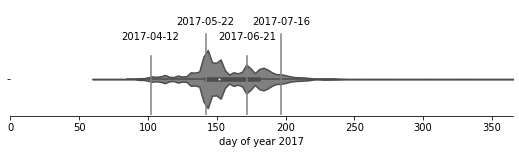

In [12]:
dates = [
    "2017-04-12",
    "2017-05-22",
    "2017-06-21",
    "2017-07-16"
]
doys = [datetime.datetime.strptime(d,"%Y-%m-%d").timetuple().tm_yday for d in dates]

fig, ax = plt.subplots(figsize=(9,2))
seaborn.violinplot(x=doy_stop,orient="h",ax=ax, color="gray")
seaborn.despine(offset=0.5, left=True)
ax.set_xlabel("day of year 2017")
ax.set_ylabel("")
ax.set_xlim(0,365)
t = np.linspace(0,360,4)
ax.set_ylim(-.5,1)
ys = [0.55,0.75,0.55,0.75]
for d, dt,y in zip(doys, dates,ys):
    ax.axvline(d, ymax=y, color="gray")
    ax.text(d,y,dt,ha="center")
#ax.set_xticks(doys)
#ax.set_xticklabels(dates, rotation=20, ha='right')
fig.savefig("/tmp/violin.pdf",dpi=300,bbox_inches='tight')

## Plot stopping times per class

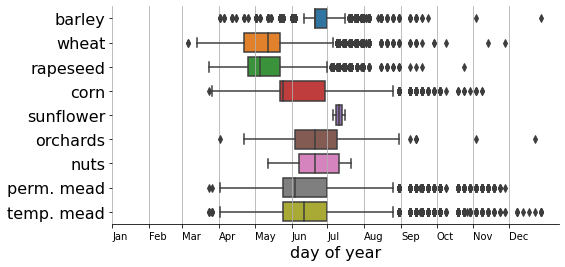

In [13]:
import seaborn
import matplotlib.pyplot as plt

doys_months = [datetime.datetime(2017,m,1).timetuple().tm_yday for m in range(1,13)]
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]


labels_names = ['barley', 'wheat', 'rapeseed', 'corn', 'sunflower', 'orchards',
       'nuts', 'perm. mead', 'temp. mead']

fig, ax = plt.subplots(figsize=(8,4))
seaborn.boxplot(x=doy_stop,y=stats["targets"][:,0],orient="h",ax=ax)
ax.set_yticklabels(labels_names, fontsize=16)
ax.set_xlabel("day of year", fontsize=16)
ax.xaxis.grid(True)
ax.set_xticks(doys_months)
ax.set_xticklabels(months, ha="left")
seaborn.despine(left=True)
fig.savefig("/home/marc/projects/re-elects/images/phenology/breizhcrops.pdf", transparent=True, bbox_inches="tight")

## Check which class differences are statistically significant (pvalue < 0.05)

In [14]:
from itertools import product

rapeseed_stops = doy_stop[stats["targets"][:,0] == labels_names.index("rapeseed")]
rapeseed_stops.mean(), rapeseed_stops.std(), np.median(rapeseed_stops), datetime.datetime(2017,1,1) + datetime.timedelta(days=125.0)

from itertools import product

barley_stops = doy_stop[stats["targets"][:,0] == labels_names.index("barley")]
barley_stops.mean(), barley_stops.std(), np.median(barley_stops), datetime.datetime(2017,1,1) + datetime.timedelta(days=int(barley_stops.mean()))

from scipy import stats as st

def print_statistic(lab1, lab2):
    A = doy_stop[stats["targets"][:,0] == labels_names.index(lab1)]
    B = doy_stop[stats["targets"][:,0] == labels_names.index(lab2)]

    test = st.ks_2samp(A, B)
    print(f"{lab1} vs {lab2}: KS-distance {test.statistic:.2f}, pvalue {test.pvalue:.2f}")
    
for lab1, lab2 in product(labels_names,labels_names):
    print_statistic(lab1, lab2)

barley vs barley: KS-distance 0.00, pvalue 1.00
barley vs wheat: KS-distance 0.83, pvalue 0.00
barley vs rapeseed: KS-distance 0.80, pvalue 1.00
barley vs corn: KS-distance 0.60, pvalue 0.00
barley vs sunflower: KS-distance 0.77, pvalue 0.10
barley vs orchards: KS-distance 0.23, pvalue 0.00
barley vs nuts: KS-distance 0.24, pvalue 0.47
barley vs perm. mead: KS-distance 0.46, pvalue 0.00
barley vs temp. mead: KS-distance 0.45, pvalue 0.00
wheat vs barley: KS-distance 0.83, pvalue 0.00
wheat vs wheat: KS-distance 0.00, pvalue 1.00
wheat vs rapeseed: KS-distance 0.11, pvalue 0.00
wheat vs corn: KS-distance 0.46, pvalue 0.00
wheat vs sunflower: KS-distance 0.91, pvalue 0.02
wheat vs orchards: KS-distance 0.71, pvalue 0.00
wheat vs nuts: KS-distance 0.68, pvalue 0.00
wheat vs perm. mead: KS-distance 0.63, pvalue 0.00
wheat vs temp. mead: KS-distance 0.59, pvalue 0.00
rapeseed vs barley: KS-distance 0.80, pvalue 1.00
rapeseed vs wheat: KS-distance 0.11, pvalue 0.00
rapeseed vs rapeseed: KS-d

## Plot Correct vs Incorrect Stopping Times

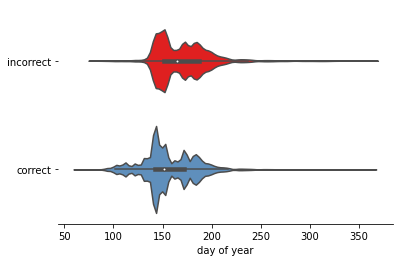

In [15]:
correct = stats["predictions_at_t_stop"][:,0] == stats["targets"][:,0]

canard = "#007480"
grosseile = "#b51f1f"
rouge = "#FF0000"
leman = "#00A79F"
acier = "#4F8FCC"

fig, ax = plt.subplots(figsize=(6,4))
seaborn.violinplot(x=doy_stop,y=correct,orient="h",ax=ax, palette=[rouge,acier])
ax.set_yticklabels(["incorrect", "correct"])
seaborn.despine(left=True)
ax.set_xlabel("day of year")
fig.savefig("/tmp/correctwrongbzhviolin.pdf")

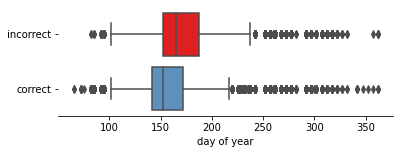

In [16]:
fig, ax = plt.subplots(figsize=(6,2))
seaborn.boxplot(x=doy_stop,y=correct,orient="h",ax=ax, palette=[rouge,acier])
ax.set_yticklabels(["incorrect", "correct"])
seaborn.despine(left=True)
ax.set_xlabel("day of year")
fig.savefig("/tmp/correctwrongbzhboxplot.pdf", bbox_inches="tight")

In [17]:
mean_correct = doy_stop[correct].mean()
mean_wrong = doy_stop[~correct].mean()
std_correct = doy_stop[correct].std()
std_wrong = doy_stop[~correct].std()

Ts = stats["seqlengths"]
t_stop = stats["t_stop"][:,0]
earliness = 1-(t_stop / Ts)

from scipy import stats as st
st.ks_2samp(doy_stop[correct], doy_stop[~correct])

KstestResult(statistic=0.24757978407260184, pvalue=0.0)

In [18]:
print(datetime.date(2017, 1, 1) + datetime.timedelta(int(mean_correct) - 1))
print(datetime.date(2017, 1, 1) + datetime.timedelta(int(mean_wrong) - 1))

2017-06-05
2017-06-18


## Plot class and stopping probability

In [22]:
stats = test("breizhcropsa0.5.pth")

nclasses = 9
input_dim = 13
model = EarlyRNN(nclasses=nclasses, input_dim=input_dim).to(device)
model.load_state_dict(torch.load("breizhcropsa0.5.pth"))
model.eval()

def ndvi(X):
    BANDS = ['B1', 'B10', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8',
            'B8A', 'B9']
    red = X[BANDS.index("B4")]
    nir = X[BANDS.index("B8A")]
    return (nir-red)/(nir+red)

dates_of_interest = [
    "2017-01-25",
    "2017-04-22",
    "2017-06-01",
    "2017-07-09",
    "2017-08-25"
] 



doys_of_interest = [datetime.datetime.strptime(d,"%Y-%m-%d").timetuple().tm_yday for d in dates_of_interest]

def add_doys_lines(ax):
    for d in doys_of_interest:
        ax.axvline(d)
        
def plot(doys, class_probabilities, stop_probabilities):
    fig, axs = plt.subplots(2,1, figsize=(6,4), sharex=True)
    seaborn.despine()
    ax = axs[0]
    ax.plot(doys, class_probabilities)
    #ax.set_xlabel("day of year")
    ax.set_ylabel("class score")
    add_doys_lines(ax)

    ax = axs[1]
    ax.plot(doys, stop_probabilities)
    ax.set_xlabel("day of year")
    ax.set_ylabel("stopping probability")
    add_doys_lines(ax)
    
def plot_id(id):
    idx = list(stats["ids"][:,0]).index(id)

    X,y, id = test_ds[idx]
    doys = doys_dict.flat[0][id]

    t_stop = stats["t_stop"][idx,0]
    doy_stop = doys[t_stop]
    date_stop = datetime.datetime(2017,1,1) + datetime.timedelta(days=int(doy_stop-1))

    msk = X[:,0]>0
    X = X[msk]
    X = X.unsqueeze(0).to(device)
    log_class_probabilities, probability_stopping = model(X)

    class_probabilities = log_class_probabilities[0].cpu().detach().exp()
    stop_probabilities = probability_stopping[0].cpu().detach()

    plot(doys, class_probabilities, stop_probabilities)


    print(id)

    y = stats["targets"][idx,0]
    print(f"class {y}")

    pred = stats["predictions_at_t_stop"][idx,0]
    print(f"pred {pred}")

    print(t_stop, doy_stop, date_stop)

  0%|          | 0/479 [00:00<?, ?it/s]

6052609
class 2
pred 2
22 115 2017-04-25 00:00:00
6052610
class 3
pred 3
29 152 2017-06-01 00:00:00
6047524
class 8
pred 8
29 152 2017-06-01 00:00:00
6047526
class 3
pred 3
29 152 2017-06-01 00:00:00


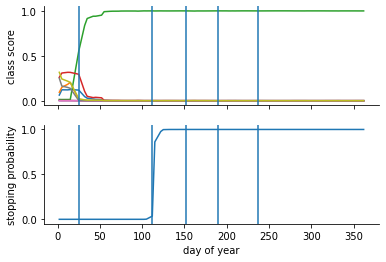

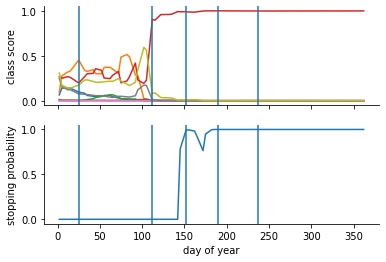

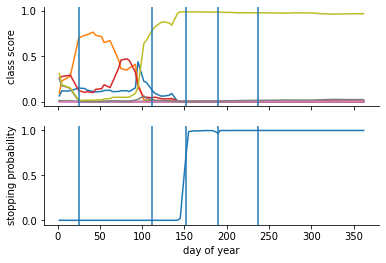

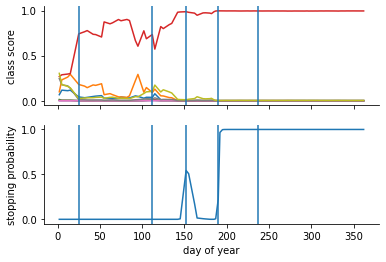

In [23]:
plot_id(6052609)
plot_id(6052610)
plot_id(6047524)
plot_id(6047526)

## Plot Two Qualitative Samples

6052609
class 2
pred 2
22 115 2017-04-25 00:00:00


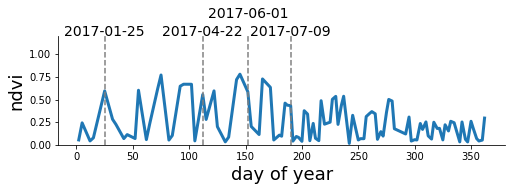

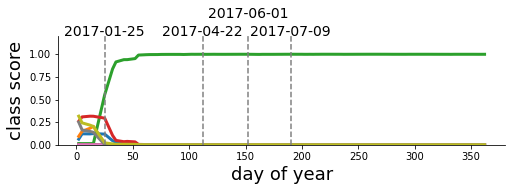

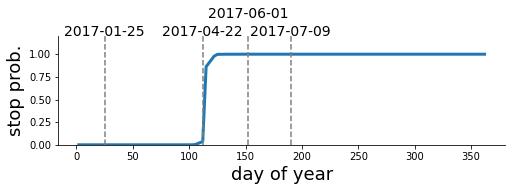

In [24]:
id = 6052609


dates_of_interest = [
    "2017-01-25",
    "2017-04-22",
    "2017-06-01",
    "2017-07-09"
] 

ymaxs = [1.2,1.2,1.4,1.2]
ymins = [0,0,0,0]
doys_of_interest = [datetime.datetime.strptime(d,"%Y-%m-%d").timetuple().tm_yday for d in dates_of_interest]

def add_doys_lines(ax):
    for d, date, ymax, ymin in zip(doys_of_interest, dates_of_interest, ymaxs, ymins):
        ax.axvline(d, color="gray", ymin=ymin, ymax=ymax, linestyle="--")
        ax.text(d, ymax,date, ha="center", fontsize=14)

labs = ['barley', 'wheat', 'rapeseed', 'corn', 'sunflower', 'orchards',
       'nuts', 'perm. mead', 'temp. mead']
        
    
figsize=(8,2)
store_path = "/tmp"

idx = list(stats["ids"][:,0]).index(id)

X,y, id = test_ds[idx]
doys = doys_dict.flat[0][id]

t_stop = stats["t_stop"][idx,0]
doy_stop = doys[t_stop]
date_stop = datetime.datetime(2017,1,1) + datetime.timedelta(days=int(doy_stop-1))

msk = X[:,0]>0
X = X[msk]
X = X.unsqueeze(0).to(device)
log_class_probabilities, probability_stopping = model(X)

fig, ax = plt.subplots(1,1, figsize=figsize)
ax.plot(doys, ndvi(X[0,:,:].T).cpu(), linewidth=3)
ax.set_ylabel("ndvi", fontsize=18)
ax.set_xlabel("day of year", fontsize=18)
seaborn.despine()
ax.set_ylim(0,1.2)
add_doys_lines(ax)
fig.savefig(os.path.join(store_path,"input.pdf"))


fig, ax = plt.subplots(1,1, figsize=figsize)
ax.plot(doys, log_class_probabilities[0].cpu().detach().exp(), linewidth=3)
ax.set_xlabel("day of year", fontsize=18)
ax.set_ylabel("class score", fontsize=18)
add_doys_lines(ax)
seaborn.despine()
ax.set_ylim(0,1.2)
ax.set_ylim(0,1.2)
#ax.legend(labs, ncol=5, bbox_to_anchor=(0, 0, 1, -0.3))
fig.savefig(os.path.join(store_path,"proba_class.pdf"), bbox_inches="tight",transparent=True)

fig, ax = plt.subplots(1,1, figsize=figsize)
ax.plot(doys, probability_stopping[0].cpu().detach(), linewidth=3)
ax.set_xlabel("day of year", fontsize=18)
ax.set_ylabel("stop prob.", fontsize=18)
add_doys_lines(ax)
ax.set_ylim(0,1.2)
seaborn.despine()
fig.savefig(os.path.join(store_path,"proba_stop.pdf"), bbox_inches="tight",transparent=True)
print(id)

y = stats["targets"][idx,0]
print(f"class {y}")

pred = stats["predictions_at_t_stop"][idx,0]
print(f"pred {pred}")

print(t_stop, doy_stop, date_stop)


6047524
class 8
pred 8
29 152 2017-06-01 00:00:00


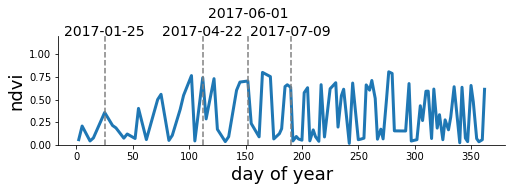

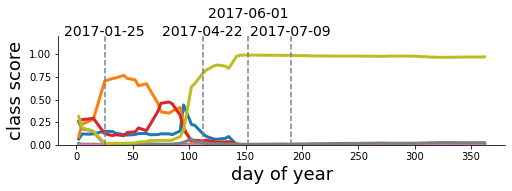

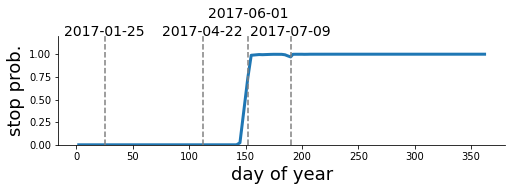

In [25]:
id = 6047524

        
figsize=(8,2)
    
import os
store_path = "/tmp"

idx = list(stats["ids"][:,0]).index(id)

X,y, id = test_ds[idx]
doys = doys_dict.flat[0][id]

t_stop = stats["t_stop"][idx,0]
doy_stop = doys[t_stop]
date_stop = datetime.datetime(2017,1,1) + datetime.timedelta(days=int(doy_stop-1))

msk = X[:,0]>0
X = X[msk]
X = X.unsqueeze(0).to(device)
log_class_probabilities, probability_stopping = model(X)

fig, ax = plt.subplots(1,1, figsize=figsize)
ax.plot(doys, ndvi(X[0,:,:].T).cpu(), linewidth=3)
ax.set_ylabel("ndvi", fontsize=18)
ax.set_xlabel("day of year", fontsize=18)
seaborn.despine()
ax.set_ylim(0,1.2)
add_doys_lines(ax)
fig.savefig(os.path.join(store_path,"input2.pdf"))


fig, ax = plt.subplots(1,1, figsize=figsize)
ax.plot(doys, log_class_probabilities[0].cpu().detach().exp(), linewidth=3)
ax.set_xlabel("day of year", fontsize=18)
ax.set_ylabel("class score", fontsize=18)
add_doys_lines(ax)
seaborn.despine()
ax.set_ylim(0,1.2)
ax.set_ylim(0,1.2)
#ax.legend(labs, ncol=5, bbox_to_anchor=(0, 0, 1, -0.3))
fig.savefig(os.path.join(store_path,"proba_class2.pdf"), bbox_inches="tight",transparent=True)

fig, ax = plt.subplots(1,1, figsize=figsize)
ax.plot(doys, probability_stopping[0].cpu().detach(), linewidth=3)
ax.set_xlabel("day of year", fontsize=18)
ax.set_ylabel("stop prob.", fontsize=18)
add_doys_lines(ax)
ax.set_ylim(0,1.2)
seaborn.despine()
fig.savefig(os.path.join(store_path,"proba_stop2.pdf"), bbox_inches="tight",transparent=True)
print(id)

y = stats["targets"][idx,0]
print(f"class {y}")

pred = stats["predictions_at_t_stop"][idx,0]
print(f"pred {pred}")

print(t_stop, doy_stop, date_stop)


## Qualitative Plots in a window

In [27]:
import geopandas as gpd
import breizhcrops as bzh
from shapely.geometry import Polygon

coords = [[-2.4051745919139944, 47.55745967351906],
          [-2.4051745919139944, 47.53283666582435],
          [-2.365263321772393, 47.53283666582435],
          [-2.365263321772393, 47.55745967351906]]

polygon_geom = Polygon(coords)


polygon = gpd.GeoDataFrame(index=[0], crs=4326, geometry=[polygon_geom])    

ds = bzh.BreizhCrops("frh04", root=data_root, transform=lambda x: x, preload_ram=False, recompile_h5_from_csv=False, year=2017)
gdf = ds.geodataframe().to_crs(4326)
  

frh04.tar.gz: 41.9MB [00:13, 3.16MB/s]                                          


In [28]:
fields = gdf.sjoin(polygon, how="inner")

<AxesSubplot:>

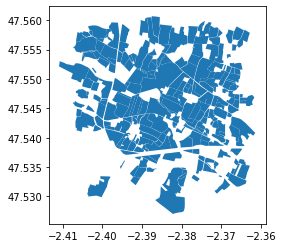

In [29]:
fields.plot()

In [30]:
# select subset of stats
msk = np.isin(stats["ids"][:,0], fields.id.values)
msk.sum()

sel_stats = {}
for k,v in stats.items():
    sel_stats[k] = v[msk]
    
doy_stop = []
for id, t_stop in zip(sel_stats["ids"][:,0], sel_stats["t_stop"][:,0]):
    doys = doys_dict.flat[0][id]
    doy_stop.append(doys[t_stop-1])
doy_stop = np.array(doy_stop)
sel_stats["doy_stop"] = doy_stop

summary = pd.DataFrame(
    [sel_stats["ids"][:,0], sel_stats["doy_stop"], sel_stats["predictions_at_t_stop"][:,0], sel_stats["targets"][:,0]], 
                       index=["id","doy_stop","predictions_at_t_stop","targets"]).T.set_index("id")

In [31]:
annot_fields = fields.set_index("id").join(summary)
annot_fields["correct"] = annot_fields["targets"] == annot_fields["predictions_at_t_stop"]
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

canard = "#007480"
grosseile = "#b51f1f"
rouge = "#FF0000"
leman = "#00A79F"
acier = "#4F8FCC"


newcmp = ListedColormap([grosseile, acier])
stopped_cmap = ListedColormap(["white","black"])


classes_cmap = ListedColormap(["#3274A1", "#E1812C", "#3A913A", "#C03D3E", "#886BA3", "#845B53", "#D584BD", "#7F7F7F", "#A9AA35"])

storepath = "/tmp/maps/"
os.makedirs(storepath, exist_ok=True)

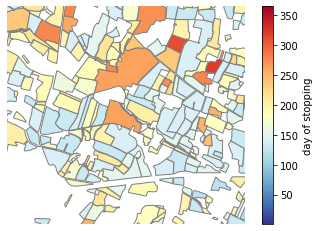

In [32]:
import contextily as cx
import matplotlib.pyplot as plt
import os
fig, ax = plt.subplots()

tifroot = "/home/marc/projects/re-elects/images/frh04"

xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis("off")
annot_fields.plot(column="doy_stop", ax=ax, cmap="RdYlBu_r", vmin=1, 
                  vmax=365, legend=True, edgecolor="gray", legend_kwds={'label': 'day of stopping', "orientation": "vertical"})
fig.savefig(os.path.join(storepath,"doy_stop.pdf"), bbox_inches="tight",transparent=True)
#cx.add_basemap(ax, crs=annot_fields.crs.to_string(),source=os.path.join(tifroot, "20170412.tif"))

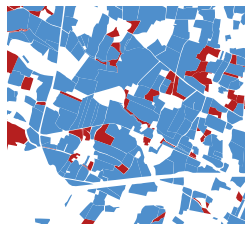

In [33]:
import contextily as cx
import matplotlib.pyplot as plt
import os
fig, ax = plt.subplots()


xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis("off")

annot_fields.plot(column="correct", ax=ax, cmap=newcmp)
fig.savefig(os.path.join(storepath,"correct.pdf"), bbox_inches="tight",transparent=True)
#cx.add_basemap(ax, crs=annot_fields.crs.to_string(),source=os.path.join(tifroot, "20170412.tif"))

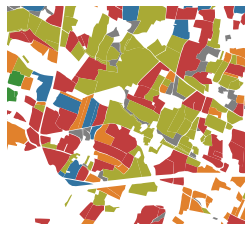

In [34]:
import contextily as cx
import matplotlib.pyplot as plt
import os
fig, ax = plt.subplots()

xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis("off")

annot_fields.plot(column="targets", ax=ax, cmap=classes_cmap)
fig.savefig(os.path.join(storepath,"targets.pdf"), bbox_inches="tight",transparent=True)

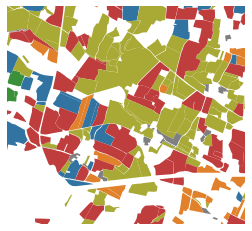

In [35]:
import contextily as cx
import matplotlib.pyplot as plt
import os
fig, ax = plt.subplots()


xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.axis("off")

annot_fields.plot(column="predictions_at_t_stop", ax=ax, cmap=classes_cmap)
fig.savefig(os.path.join(storepath,"predictions.pdf"), bbox_inches="tight",transparent=True)

In [36]:
dates_of_interest = ["2017-04-12","2017-05-22","2017-06-21","2017-07-16"]
doys_of_interest = [datetime.datetime.strptime(d,"%Y-%m-%d").timetuple().tm_yday for d in dates_of_interest]

## Qualitative Samples at different times

/home/marc/anaconda3/envs/elects/lib/python3.7/site-packages/geopandas/plotting.py:684: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


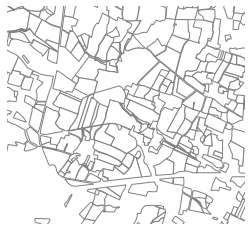

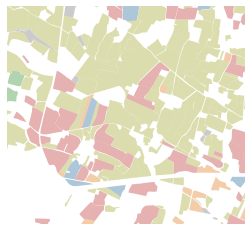

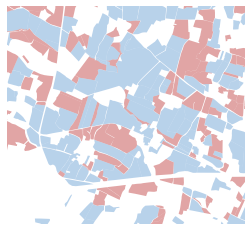

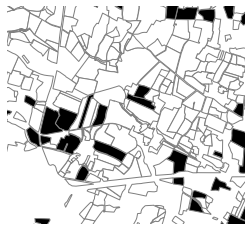

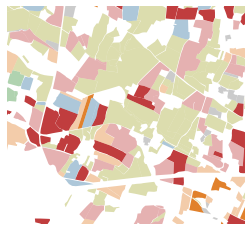

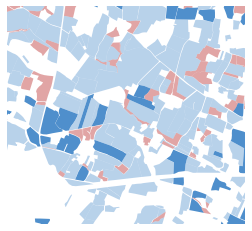

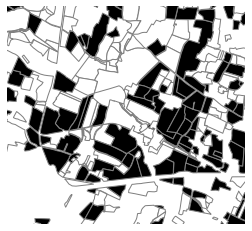

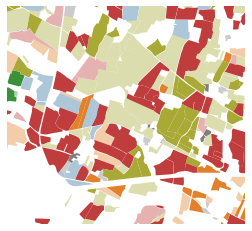

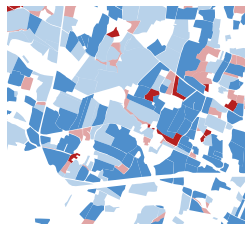

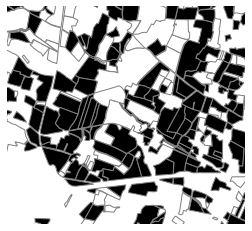

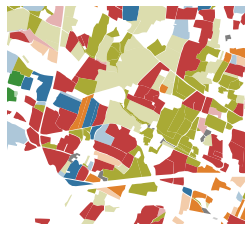

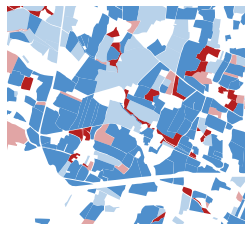

In [37]:
alpha=0.4

for doy, date in zip(doys_of_interest, dates_of_interest):
    annot_fields["stopped_before_doy"] = annot_fields["doy_stop"] < doy
    
    t_stop = np.argwhere(doys==doy)[0]
    annot_fields["prediction_at_doy"] = sel_stats["class_probabilities"].argmax(2)[:,t_stop][:,0]
    
    annot_fields["correct_at_doy"] = annot_fields["prediction_at_doy"] == annot_fields["targets"]
    
    

    fig, ax = plt.subplots()
    xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axis("off")
    annot_fields.plot(column="stopped_before_doy", ax=ax, cmap=stopped_cmap,  edgecolor='gray')
    fig.savefig(os.path.join(storepath,f"stopped_at_date_{date}.pdf"), bbox_inches="tight",transparent=True)
    
    fig, ax = plt.subplots()
    xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axis("off")
    if annot_fields["stopped_before_doy"].sum() > 0:
        annot_fields.loc[annot_fields["stopped_before_doy"]].plot(column="prediction_at_doy", 
                                                                  ax=ax, cmap=classes_cmap, vmin=0, vmax=8)
        annot_fields.loc[~annot_fields["stopped_before_doy"]].plot(column="prediction_at_doy", 
                                                                  ax=ax, cmap=classes_cmap, alpha=alpha, vmin=0, vmax=8)
    else:
        annot_fields.plot(column="prediction_at_doy", ax=ax, cmap=classes_cmap, alpha=alpha, vmin=0, vmax=8)
        
    fig.savefig(os.path.join(storepath,f"prediction_at_date_{date}.pdf"), bbox_inches="tight",transparent=True)
    
    fig, ax = plt.subplots()
    xmin, ymin, xmax, ymax = polygon.geometry.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axis("off")
    
    if annot_fields["correct_at_doy"].sum() > 0:
        annot_fields.loc[annot_fields["stopped_before_doy"]].plot(column="correct_at_doy", 
                                                                  ax=ax, cmap=newcmp, vmin=0, vmax=1)
        annot_fields.loc[~annot_fields["stopped_before_doy"]].plot(column="correct_at_doy", 
                                                                  ax=ax, cmap=newcmp, alpha=alpha, vmin=0, vmax=1)
    else:
        annot_fields.plot(column="correct_at_doy", ax=ax, cmap=newcmp, alpha=alpha, vmin=0, vmax=1)
        
    fig.savefig(os.path.join(storepath,f"correct_at_doy_{date}.pdf"), bbox_inches="tight",transparent=True)